# Capital Bike Share Diaries: Data Mining Project

## 1. Introduction

### 1.1. Project Overview
* Briefly describe the project's goal (analyzing daily bike trips in Washington D.C.).

### 1.2. Objectives
* List the main objectives as stated in the document (understanding usage patterns, weather impact, high activity zones, etc.).

### 1.3. Datasets
* List the datasets to be used (Daily Bikes Trips, Daily Weather Info, Stations Info, etc.).

### 1.4. Tools and Libraries
* Mention the programming language (Python) and permitted frameworks (Pandas, NumPy, Plotly, Scikit-Learn, etc.).

## 2. Setup Environment

#### 2.0.1 Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 2.0.2 Installing Libraries

In [3]:
%%capture
!pip install geopandas
!pip install -U shapely pyproj rtree
!pip install pygeohash
!pip install missingno
!pip install folium
!pip install geopy

### 2.1. Import Libraries

In [2]:
# Import necessary libraries
import os

import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import folium
import pygeohash
import missingno as msno
from scipy import stats
from shapely.geometry import Point
import geopandas as gpd
from scipy.spatial import KDTree
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
# from prophet import Prophet # Uncomment if using Prophet
import datetime
import math

### 2.2. Load Datasets
* Load each dataset into pandas/geopandas DataFrames.
* Display the head and info for each dataset to get a first look.

In [4]:
data_folder_path = "/content/drive/MyDrive/Data Mining Homework/Homework 01/data"

# List the files in the data folder
files = [f for f in os.listdir(data_folder_path) if os.path.isfile(os.path.join(data_folder_path, f))]

# Create a dictionary to store dataframes
dataframes = {}

# Load each file into a pandas DataFrame
for file_name in files:
    file_path = os.path.join(data_folder_path, file_name)
    try:
        df_name = os.path.splitext(file_name)[0] # Use filename without extension as dataframe key
        if file_name.endswith('.csv'):
            dataframes[df_name] = pd.read_csv(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        elif file_name.endswith('.parquet'):
            dataframes[df_name] = pd.read_parquet(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        elif file_name.endswith('.geojson'):
            # You might need to install geopandas: pip install geopandas
            dataframes[df_name] = gpd.read_file(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        else:
            print(f"Skipping unknown file type: {file_name}")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

Successfully loaded DDOT_Central_Business_District.geojson into dataframe 'DDOT_Central_Business_District'
Successfully loaded Residential_and_Visitor_Parking_Zones.geojson into dataframe 'Residential_and_Visitor_Parking_Zones'
Successfully loaded Capital_Bikeshare_Locations.csv into dataframe 'Capital_Bikeshare_Locations'
Successfully loaded Washington,DC,USA 2024-01-01 to 2024-12-31.csv into dataframe 'Washington,DC,USA 2024-01-01 to 2024-12-31'
Successfully loaded Metro_Bus_Stops.csv into dataframe 'Metro_Bus_Stops'
Successfully loaded Shuttle_Bus_Stops.csv into dataframe 'Shuttle_Bus_Stops'
Successfully loaded stations.csv into dataframe 'stations'
Successfully loaded daily-rent-sampled.parquet into dataframe 'daily-rent-sampled'
Successfully loaded daily-rent.parquet into dataframe 'daily-rent'


Data Frames names:
- Daily Bikes Trips
- Daily Weather Info
- Stations Info Dataset
- Stations Table
- CBD Polygon
- Metro Bus Stops
- Shuttle Bus Stops
- Residential and Visitor Parking Zones

In [5]:
stations_info_df = dataframes['Capital_Bikeshare_Locations']
metro_bus_stops_df = dataframes['Metro_Bus_Stops']
shuttle_bus_stops_df = dataframes['Shuttle_Bus_Stops']
daily_weather_info_df = dataframes['Washington,DC,USA 2024-01-01 to 2024-12-31']
daily_bikes_trips_df = dataframes['daily-rent']
stations_table_df = dataframes['stations']
cbd_polygon_df = dataframes['DDOT_Central_Business_District']
residential_and_visitor_parking_zones_df = dataframes['Residential_and_Visitor_Parking_Zones']

## 3. Data Cleaning and Integration (Preprocessing)

### 3.1. Initial Data Inspection
* Check for missing values (`.isnull().sum()`).
* Check data types (`.dtypes`).
* Check for duplicates (`.duplicated().sum()`).
* Basic descriptive statistics (`.describe(include='all')`).

##### 3.1.1 For Daily Bikes Trips


###### Data Info

In [ ]:
daily_bikes_trips_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59,2024-01-25 15:52:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58,2024-01-02 16:53:25,1st & O St NW,31519,4th & College St NW,31138,38.908643,-77.012365,38.921233,-77.018135,member
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15,2024-01-24 15:43:55,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00,2024-01-04 15:37:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58,2024-01-05 12:35:40,1st & O St NW,31519,10th & G St NW,31274,38.908690,-77.012317,38.898243,-77.026235,casual


In [ ]:
daily_bikes_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6114323 entries, 0 to 6114322
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   start_station_id    string        
 6   end_station_name    string        
 7   end_station_id      string        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       string        
dtypes: datetime64[ns](2), float64(4), string(7)
memory usage: 606.4 MB


In [ ]:
daily_bikes_trips_df.describe(include='all')

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
count,6114323,6114323,6114323,6114323,4923357,4923357,4878156,4876629,6.114323e+06,6.114323e+06,6.109673e+06,6.109673e+06,6114323
unique,6114182,2,NaN,NaN,818,803,818,803,NaN,NaN,NaN,NaN,2
top,9600846638F174F7,electric_bike,NaN,NaN,Columbus Circle / Union Station,31623,Columbus Circle / Union Station,31623,NaN,NaN,NaN,NaN,member
freq,2,3404885,NaN,NaN,55508,55508,55458,55437,NaN,NaN,NaN,NaN,4059247
mean,NaN,NaN,2024-07-18 16:52:01.082998016,2024-07-18 18:43:22.552895744,NaN,NaN,NaN,NaN,3.890560e+01,-7.703176e+01,3.890488e+01,-7.703157e+01,NaN
min,NaN,NaN,1970-01-01 00:00:00,2000-01-01 15:55:56,NaN,NaN,NaN,NaN,-8.960010e+01,-1.716215e+02,-8.839068e+01,-1.723373e+02,NaN
25%,NaN,NaN,2024-05-03 10:55:45.500000,2024-05-03 11:15:35.500000,NaN,NaN,NaN,NaN,3.889287e+01,-7.704440e+01,3.889227e+01,-7.704442e+01,NaN
50%,NaN,NaN,2024-07-26 11:27:16.340999936,2024-07-26 11:47:01.260000,NaN,NaN,NaN,NaN,3.890550e+01,-7.703000e+01,3.890383e+01,-7.703000e+01,NaN
75%,NaN,NaN,2024-10-06 17:20:19.227500032,2024-10-06 17:41:45.916499968,NaN,NaN,NaN,NaN,3.891902e+01,-7.701162e+01,3.891776e+01,-7.701082e+01,NaN
max,NaN,NaN,2024-12-31 23:54:46.421000,2030-01-01 00:00:00,NaN,NaN,NaN,NaN,8.582003e+01,5.993410e+01,8.957352e+01,5.730187e+01,NaN


###### Unique Values

In [ ]:
daily_bikes_trips_df.nunique()

,0
ride_id,6114182
rideable_type,2
started_at,5866403
ended_at,5869571
start_station_name,818
start_station_id,803
end_station_name,818
end_station_id,803
start_lat,468450
start_lng,501510


###### Duplicated Rows

In [ ]:
print(daily_bikes_trips_df.duplicated().sum())

0


In [ ]:
print(daily_bikes_trips_df.duplicated(subset=['ride_id']).sum())

141


In [ ]:
duplicated_rows = daily_bikes_trips_df[daily_bikes_trips_df.duplicated(subset=['ride_id'], keep=False)]
duplicated_rows.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1493305,A0D6E0D07416BB2A,classic_bike,2024-05-31 23:12:54,2024-06-01 00:07:43,Gravelly Point,31064,Potomac Ave & Swann Ave,31916,38.865029,-77.039511,38.829545,-77.047844,member
1504876,3274F26728D10261,classic_bike,2024-05-31 20:58:48,2024-06-01 04:06:37,Smithsonian-National Mall / Jefferson Dr & 12t...,31248,Wisconsin Ave & Rodman St NW,31333,38.888774,-77.028694,38.939674,-77.075277,casual
1506981,A9A7B0B468FBBE1B,classic_bike,2024-05-31 07:56:41,2024-06-01 08:15:58,8th & Eye St SE / Barracks Row,31608,1st & I St SE,31628,38.879200,-76.995300,38.878854,-77.005727,member
1508631,3377EF31A5964D3C,classic_bike,2024-05-31 07:39:54,2024-06-01 08:15:58,C & O Canal & Wisconsin Ave NW,31225,1st & I St SE,31628,38.903750,-77.062690,38.878854,-77.005727,member
1509898,59798416D0A9F527,classic_bike,2024-05-31 09:15:14,2024-06-01 08:15:58,1st & M St SE,31650,1st & I St SE,31628,38.876893,-77.006072,38.878854,-77.005727,member


In [6]:
daily_bikes_trips_df = daily_bikes_trips_df.drop_duplicates(subset=['ride_id'], keep='first')

###### Null Values

In [ ]:
print(daily_bikes_trips_df.isnull().sum())

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1190966
start_station_id      1190966
end_station_name      1236167
end_station_id        1237694
start_lat                   0
start_lng                   0
end_lat                  4650
end_lng                  4650
member_casual               0
dtype: int64


In [ ]:
count = daily_bikes_trips_df[daily_bikes_trips_df[['end_station_id',"end_station_name", 'end_lat',"end_lng"]].isna().all(axis=1)].shape[0]
print(f"Number of rows that have missing values in ['end_station_id','end_station_name', 'end_lat','end_lng']:\n{count}")

Number of rows that have missing values in ['end_station_id','end_station_name', 'end_lat','end_lng']:
4637


In [ ]:
count = daily_bikes_trips_df[daily_bikes_trips_df[['end_station_id',"end_station_name"]].isna().all(axis=1)].shape[0]
print(f"Number of rows that have missing values in ['end_station_id','end_station_name']:\n{count}")

Number of rows that have missing values in ['end_station_id','end_station_name']:
1236126


In [ ]:
count = daily_bikes_trips_df[daily_bikes_trips_df[['start_station_id',"start_station_name"]].isna().all(axis=1)].shape[0]
print(f"Number of rows that have missing values in ['start_station_id','start_station_name']:\n{count}")

Number of rows that have missing values in ['start_station_id','start_station_name']:
1190946


<Axes: >

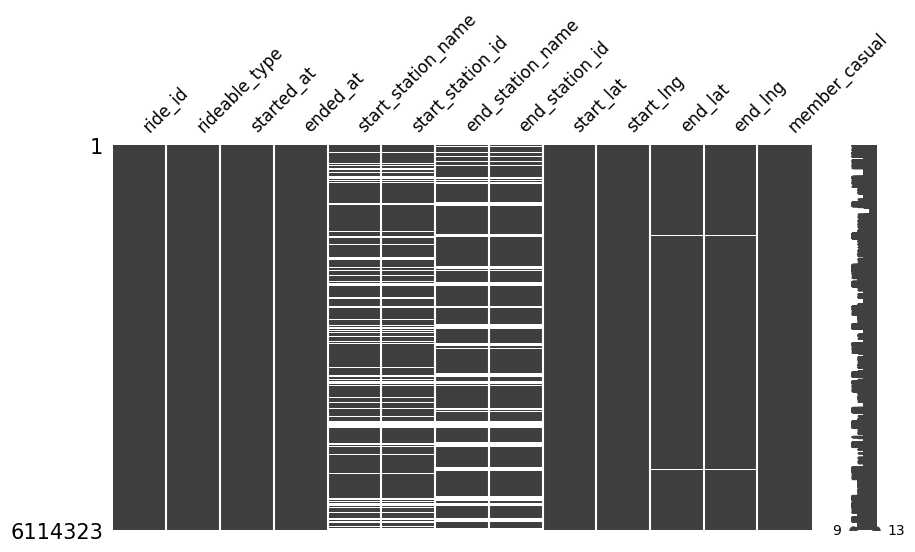

In [ ]:
msno.matrix(daily_bikes_trips_df, figsize=(10,5), fontsize=12)

<Axes: >

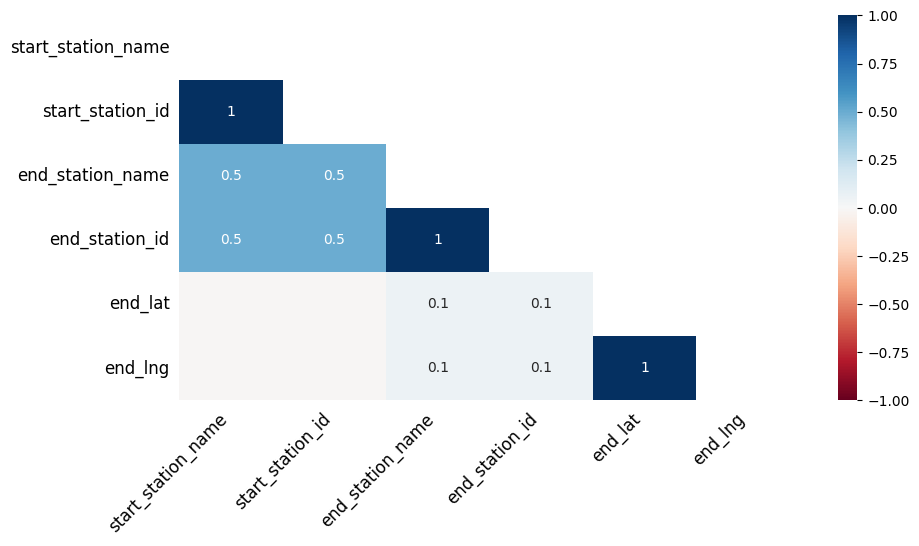

In [ ]:
msno.heatmap(daily_bikes_trips_df,figsize=(10,5), fontsize=12)

<Axes: >

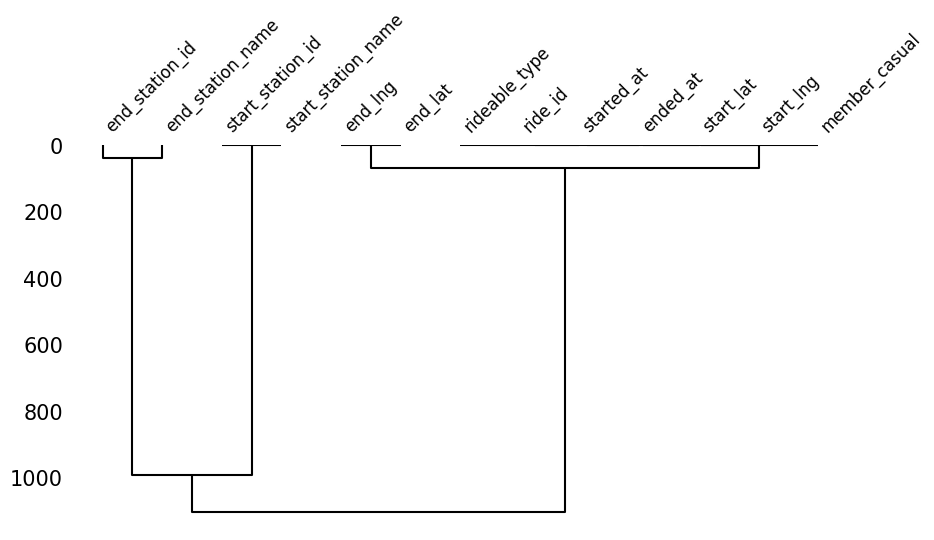

In [ ]:
msno.dendrogram(daily_bikes_trips_df,figsize=(10,5), fontsize=12)

######Out layer

In [ ]:
# حساب عدد الرحلات لكل نوع دراجة
bike_type_counts = daily_bikes_trips_df['rideable_type'].value_counts().reset_index()
bike_type_counts.columns = ['rideable_type', 'count']

# حساب النسبة المئوية
total_rides = bike_type_counts['count'].sum()
bike_type_counts['percentage'] = (bike_type_counts['count'] / total_rides) * 100

# إنشاء المخطط الدائري
fig = px.pie(bike_type_counts,
             values='count',
             names='rideable_type',
             title='توزيع أنواع الدراجات حسب الرحلات',
             hover_data=['percentage'],
             labels={'rideable_type':'نوع الدراجة', 'count':'عدد الرحلات', 'percentage':'النسبة المئوية'})

# تحديث تنسيق النص ليشمل النسبة المئوية
fig.update_traces(textposition='inside', textinfo='percent+label')

# عرض المخطط
fig.show()

In [7]:
# حساب مدة الرحلة بالثواني
daily_bikes_trips_df['duration'] = (daily_bikes_trips_df['ended_at'] - daily_bikes_trips_df['started_at']).dt.total_seconds()

<ipython-input-7-1991676314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_bikes_trips_df['duration'] = (daily_bikes_trips_df['ended_at'] - daily_bikes_trips_df['started_at']).dt.total_seconds()


In [8]:
# 1.  الرحلات القصيرة جداً (< 60 ثانية)
short_bikes_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['duration'] <= 60]
short_bikes_trips_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
38,D462EB06D9E394F1,electric_bike,2024-01-29 11:51:45.000,2024-01-29 11:52:30.000,Wilson Blvd & N Oak St,31939,<NA>,<NA>,38.895056,-77.073714,38.89,-77.08,member,45.000
270,9A0BF921EA05585C,electric_bike,2024-01-23 10:58:40.000,2024-01-23 10:59:37.000,14th & Harvard St NW,31105,<NA>,<NA>,38.926763,-77.032258,38.93,-77.03,member,57.000
285,0F758A88D40D4485,electric_bike,2024-01-23 18:09:17.000,2024-01-23 18:09:27.000,Neal St & Trinidad Ave NE,31512,<NA>,<NA>,38.903772,-76.987301,38.90,-76.99,member,10.000
302,40E6EFCF6F6C11F2,electric_bike,2024-01-13 15:39:12.000,2024-01-13 15:39:12.000,Metro Center / 12th & G St NW,31230,<NA>,<NA>,38.898139,-77.027641,38.90,-77.03,member,0.000
307,60A27E59B54EBAF7,electric_bike,2024-01-12 15:34:49.000,2024-01-12 15:34:56.000,Metro Center / 12th & G St NW,31230,<NA>,<NA>,38.898112,-77.028031,38.90,-77.03,casual,7.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114255,4BA07BAF30E58BF0,electric_bike,2024-12-29 11:33:02.687,2024-12-29 11:33:12.772,<NA>,<NA>,<NA>,<NA>,38.850000,-76.980000,38.85,-76.98,member,10.085
6114262,3B87866EFC037F0A,electric_bike,2024-12-29 12:51:55.717,2024-12-29 12:52:55.023,<NA>,<NA>,<NA>,<NA>,38.850000,-76.980000,38.85,-76.98,member,59.306
6114280,885259216DB56E04,electric_bike,2024-12-17 17:43:05.540,2024-12-17 17:43:12.643,Georgia Ave & Dahlia St NW,31425,<NA>,<NA>,38.976061,-77.026747,38.98,-77.03,casual,7.103
6114282,1B7A14D35DA2C764,electric_bike,2024-12-26 15:13:44.847,2024-12-26 15:14:00.384,S Randolph St & Campbell Ave,31076,<NA>,<NA>,38.840654,-77.088659,38.84,-77.09,casual,15.537


In [9]:
# 2.  الرحلات الطويلة جداً (> 24 ساعة)
long_bikes_trips_df = daily_bikes_trips_df[
    (daily_bikes_trips_df['duration'] >= 86400) &
    (daily_bikes_trips_df['end_lat'].notna()) &
    (daily_bikes_trips_df['end_lng'].notna())
]
long_bikes_trips_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
14765,45ECB714FB05AE24,classic_bike,2024-01-25 11:18:14.000,2024-01-26 12:10:40.000,Kenilworth Terr & Hayes St. NE,31717,Rhode Island Ave Metro,31516,38.900468,-76.947287,38.920682,-76.995876,casual,8.954600e+04
24024,39F7EA3B307BA4EA,classic_bike,2024-01-22 08:23:19.000,2024-01-23 09:23:00.000,Tenleytown / Wisconsin Ave & Albemarle St NW,31303,<NA>,<NA>,38.947607,-77.079382,38.940000,-77.090000,casual,8.998100e+04
45591,AD11CE697E5DC9BF,classic_bike,2024-01-06 09:30:13.000,2024-01-07 10:29:58.000,Eastern Market / 7th & North Carolina Ave SE,31610,<NA>,<NA>,38.886952,-76.996806,38.880000,-77.000000,casual,8.998500e+04
59159,5F2FAB798BF9D285,classic_bike,2024-01-01 00:28:09.000,2024-01-02 01:28:00.000,18th & C St NW,31284,<NA>,<NA>,38.893511,-77.041544,38.910000,-77.040000,casual,8.999100e+04
59188,1A12B3C3584C9759,classic_bike,2024-01-24 15:23:38.000,2024-01-25 16:23:30.000,22nd St & Constitution Ave NW,31292,<NA>,<NA>,38.892441,-77.048947,38.890000,-77.050000,casual,8.999200e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5920081,17C58119F7F14250,classic_bike,2024-12-28 21:14:29.809,2024-12-29 22:14:24.280,King St & Patrick St,31044,<NA>,<NA>,38.805317,-77.049883,38.820000,-77.050000,casual,8.999447e+04
5951849,DA0BE5328F09B50B,electric_bike,1970-01-01 00:00:00.000,2024-12-01 13:24:28.289,<NA>,<NA>,<NA>,<NA>,38.920000,-76.990000,38.910000,-77.040000,member,1.733059e+09
5957025,B00764530DF95E12,classic_bike,2024-12-27 17:26:49.553,2024-12-28 18:26:44.378,W&OD Trail & Explorer St/Reston Bus Station,32214,<NA>,<NA>,38.957037,-77.359718,38.960000,-77.350000,casual,8.999482e+04
5987188,3B4589BFC8B7E3F5,classic_bike,2024-12-18 08:58:48.595,2024-12-19 09:32:14.627,11th & Kenyon St NW,31102,15th & M St NW,31298,38.929464,-77.027822,38.905424,-77.034674,member,8.840603e+04


In [10]:
# 3.  الرحلات التي بدأت بعد انتهائها
start_after_end_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['started_at'] > daily_bikes_trips_df['ended_at']]
start_after_end_trips_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
5407,82AB913D4EF90555,electric_bike,2024-01-20 19:20:18.000,2024-01-20 19:20:17.000,Eckington Pl & Q St NE,31505,<NA>,<NA>,38.911022,-77.004981,38.910000,-77.000000,member,-1.000
6252,2A88A56C2B0B0687,electric_bike,2024-01-03 16:35:44.000,2024-01-03 16:35:41.000,Metro Center / 12th & G St NW,31230,<NA>,<NA>,38.898335,-77.027644,38.900000,-77.030000,member,-3.000
44610,50C76C14CB49538B,electric_bike,2024-01-01 19:00:15.000,2024-01-01 19:00:14.000,6th & K St NE,31645,<NA>,<NA>,38.903058,-76.998434,38.900000,-77.000000,casual,-1.000
54892,C07C8BCEC9D547FB,electric_bike,2024-01-27 17:47:05.000,2024-01-27 17:47:04.000,Takoma Metro,31408,Takoma Metro,31408,38.975203,-77.016856,38.975219,-77.016855,casual,-1.000
76685,DE163C18B49DAF6B,electric_bike,2024-01-18 07:21:03.000,2024-01-18 07:21:02.000,N Pershing Dr & N George Mason Dr,31069,<NA>,<NA>,38.871791,-77.107953,38.870000,-77.110000,casual,-1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5683846,1B558B48B9C8766A,electric_bike,2024-11-03 01:55:09.461,2024-11-03 01:09:12.902,20th & O St NW / Dupont South,31234,<NA>,<NA>,38.909048,-77.044669,38.930000,-77.020000,member,-2756.559
5684312,2AC2CE58664A8D62,electric_bike,2024-11-03 01:55:15.855,2024-11-03 01:13:28.133,Washington Blvd & Walter Reed Dr,31073,<NA>,<NA>,38.873219,-77.082104,38.850000,-77.050000,casual,-2507.722
5688849,BF57186DCB8CD5AB,electric_bike,2024-11-03 01:44:53.788,2024-11-03 01:10:10.656,13th & H St NE,31611,<NA>,<NA>,38.900427,-76.988250,38.920000,-77.040000,member,-2083.132
5691032,C4CCA7A748AED3EA,electric_bike,2024-11-03 01:15:14.831,2024-11-03 01:12:44.083,<NA>,<NA>,<NA>,<NA>,38.920000,-77.030000,38.920000,-77.030000,member,-150.748


###### Summary

- There are a 2018439 row duplicated
- Whenever end_lat and end_lng are missing, end_station_name and end_station_id are also missing for those same rows

##### 3.1.2 For Stations Table


###### Data Info

In [ ]:
stations_table_df.head()

,id,name
0,30200,9th St & Pennsylvania Ave NW
1,30201,9th & G St NW
2,31000,Eads St & 15th St S
3,31002,Crystal Dr & 20th St S
4,31003,Crystal Dr & 15th St S


In [ ]:
stations_table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      821 non-null    int64 
 1   name    821 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [ ]:
stations_table_df.describe(include='all')

,id,name
count,821.000000,821
unique,NaN,820
top,NaN,Randle Circle & Minnesota Ave SE
freq,NaN,2
mean,31650.894032,NaN
std,447.232558,NaN
min,30200.000000,NaN
25%,31263.000000,NaN
50%,31630.000000,NaN
75%,32022.000000,NaN


###### Unique Values

In [ ]:
stations_table_df.nunique()

,0
id,804
name,820


In [ ]:
rows_with_non_unique_name = stations_table_df[stations_table_df.duplicated(subset=['name'], keep=False)]
print("Rows with non-unique Names:")
rows_with_non_unique_name

Rows with non-unique Names:


,id,name
465,31702,Randle Circle & Minnesota Ave SE
492,31799,Randle Circle & Minnesota Ave SE


In [8]:
# drop duplicated name row

stations_table_df = stations_table_df.drop_duplicates(subset=['name'], keep='first')

In [ ]:
rows_with_non_unique_id = stations_table_df[stations_table_df.duplicated(subset=['id'], keep=False)]
print("Rows with non-unique IDs:")
rows_with_non_unique_id

Rows with non-unique IDs:


,id,name
45,31045,S Payne St & King St
46,31045,Commerce St & Fayette St
133,31133,20th & Columbia Rd NW
134,31133,20th St & Columbia Rd NW
135,31133,19th St & Wyoming Ave NW
166,31225,C & O Canal & Wisconsin Ave NW
167,31225,Wisconsin Ave & K St NW
281,31339,18th St & Ingleside Terr NW
282,31339,18th St & Ingleside Ter NW
284,31380,Roland Clarke Pl & Sunrise Valley Dr


###### Duplicated Rows

In [ ]:
print(stations_table_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(stations_table_df.isnull().sum())

id      0
name    0
dtype: int64


###### Summary

- There is one name duplicated "Randle Circle & Minnesota Ave SE", and 17 IDs duplicated.
- There are no missing values

##### 3.1.3 For Stations Info

###### Data Info

In [ ]:
stations_info_df.head()

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
0,-8.577104e+06,4.705679e+06,Lincoln Memorial,classic,08254284-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,17,0,8,...,NO,25,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888255,-77.049437,2025/05/05 20:27:29+00,261284028
1,-8.609481e+06,4.714716e+06,W&OD Trail/Sunset Hills Rd & Isaac Newton Sq,classic,08263fbd-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,15,0,3,...,NO,19,"KEY,CREDITCARD",104.0,DCA-CABI,NaN,38.951419,-77.340281,2025/05/05 20:27:29+00,261284029
2,-8.575867e+06,4.705657e+06,17th St & Independence Ave SW,classic,082623bf-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,10,0,6,...,NO,19,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888097,-77.038325,2025/05/05 20:27:29+00,261284030
3,-8.574188e+06,4.706622e+06,8th & D St NW,classic,08256ac9-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,0,0,24,...,NO,24,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.894851,-77.023240,2025/05/05 20:27:29+00,261284031
4,-8.567161e+06,4.706864e+06,Anacostia Ave & Benning Rd NE / River Terrace,classic,082518eb-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,4,0,10,...,NO,15,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.896544,-76.960120,2025/05/05 20:27:29+00,261284032


In [ ]:
stations_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   X                               794 non-null    float64
 1   Y                               794 non-null    float64
 2   NAME                            794 non-null    object 
 3   STATION_TYPE                    794 non-null    object 
 4   STATION_ID                      794 non-null    object 
 5   STATION_STATUS                  0 non-null      float64
 6   LAST_REPORTED                   794 non-null    object 
 7   NUM_DOCKS_AVAILABLE             794 non-null    int64  
 8   NUM_DOCKS_DISABLED              794 non-null    int64  
 9   NUM_BIKES_AVAILABLE             794 non-null    int64  
 10  NUM_EBIKES_AVAILABLE            794 non-null    int64  
 11  NUM_BIKES_DISABLED              794 non-null    int64  
 12  IS_INSTALLED                    794 

In [ ]:
stations_info_df.describe(include='all')

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
count,7.940000e+02,7.940000e+02,794,794,794,0.0,794,794.00000,794.000000,794.000000,...,794,794.000000,794,744.000000,794,0.0,794.000000,794.000000,794,7.940000e+02
unique,NaN,NaN,794,1,794,NaN,125,NaN,NaN,NaN,...,1,NaN,1,NaN,1,NaN,NaN,NaN,2,NaN
top,NaN,NaN,Old Meadow Rd & Cathy Ln,classic,1890899920583743818,NaN,2025/05/05 20:26:08+00,NaN,NaN,NaN,...,NO,NaN,"KEY,CREDITCARD",NaN,DCA-CABI,NaN,NaN,NaN,2025/05/05 20:27:29+00,NaN
freq,NaN,NaN,1,794,1,NaN,14,NaN,NaN,NaN,...,794,NaN,794,NaN,794,NaN,NaN,NaN,604,NaN
mean,-8.579029e+06,4.708386e+06,NaN,NaN,NaN,NaN,NaN,10.13728,0.021411,6.419395,...,NaN,17.234257,NaN,53.034946,NaN,NaN,38.907156,-77.066727,NaN,2.612862e+08
std,1.073636e+04,8.392150e+03,NaN,NaN,NaN,NaN,NaN,6.07810,0.271923,5.968744,...,NaN,5.712581,NaN,27.714636,NaN,NaN,0.058643,0.096446,NaN,3.217789e+03
min,-8.614982e+06,4.688330e+06,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,...,NaN,8.000000,NaN,40.000000,NaN,NaN,38.766844,-77.389696,NaN,2.612840e+08
25%,-8.582008e+06,4.704036e+06,NaN,NaN,NaN,NaN,NaN,5.00000,0.000000,2.000000,...,NaN,15.000000,NaN,42.000000,NaN,NaN,38.876769,-77.093483,NaN,2.612842e+08
50%,-8.576564e+06,4.707386e+06,NaN,NaN,NaN,NaN,NaN,10.00000,0.000000,5.000000,...,NaN,15.000000,NaN,42.000000,NaN,NaN,38.900192,-77.044581,NaN,2.612844e+08
75%,-8.572478e+06,4.711950e+06,NaN,NaN,NaN,NaN,NaN,14.00000,0.000000,10.000000,...,NaN,19.000000,NaN,43.000000,NaN,NaN,38.932094,-77.007883,NaN,2.612846e+08


###### Unique Values

In [ ]:
stations_info_df.nunique()

,0
X,794
Y,794
NAME,794
STATION_TYPE,1
STATION_ID,794
STATION_STATUS,0
LAST_REPORTED,125
NUM_DOCKS_AVAILABLE,33
NUM_DOCKS_DISABLED,3
NUM_BIKES_AVAILABLE,31


###### Duplicated Rows

In [ ]:
print(stations_info_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(stations_info_df.isnull().sum())

X                                   0
Y                                   0
NAME                                0
STATION_TYPE                        0
STATION_ID                          0
STATION_STATUS                    794
LAST_REPORTED                       0
NUM_DOCKS_AVAILABLE                 0
NUM_DOCKS_DISABLED                  0
NUM_BIKES_AVAILABLE                 0
NUM_EBIKES_AVAILABLE                0
NUM_BIKES_DISABLED                  0
IS_INSTALLED                        0
IS_RETURNING                        0
IS_RENTING                          0
HAS_KIOSK                           0
IOS                                 0
ANDROID                             0
ELECTRIC_BIKE_SURCHARGE_WAIVER      0
EIGHTD_HAS_KEY_DISPENSER            0
CAPACITY                            0
RENTAL_METHODS                      0
REGION_ID                          50
REGION_NAME                         0
GIS_ID                            794
LATITUDE                            0
LONGITUDE   

###### Merge with Stations Table Dataframe

In [9]:
stations_df = pd.merge(stations_info_df, stations_table_df, left_on='NAME', right_on='name', how='inner')
stations_df = stations_df.drop(columns=['name'])
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   X                               776 non-null    float64
 1   Y                               776 non-null    float64
 2   NAME                            776 non-null    object 
 3   STATION_TYPE                    776 non-null    object 
 4   STATION_ID                      776 non-null    object 
 5   STATION_STATUS                  0 non-null      float64
 6   LAST_REPORTED                   776 non-null    object 
 7   NUM_DOCKS_AVAILABLE             776 non-null    int64  
 8   NUM_DOCKS_DISABLED              776 non-null    int64  
 9   NUM_BIKES_AVAILABLE             776 non-null    int64  
 10  NUM_EBIKES_AVAILABLE            776 non-null    int64  
 11  NUM_BIKES_DISABLED              776 non-null    int64  
 12  IS_INSTALLED                    776 

###### Summary

- There are no duplicated rows.
- There is no data in "STATION_STATUS" and "GIS_ID" columns.

##### 3.1.4 For Daily Weather Info

###### Data Info

In [ ]:
daily_weather_info_df.head()

,name,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
0,"Washington,DC,USA",2024-01-01,6.1,3.8,4.9,74.7,21.9,21.9,11.9,0.0,90.3,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain
1,"Washington,DC,USA",2024-01-02,7.7,2.0,4.7,57.3,29.2,29.2,18.6,6.7,47.5,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,"Washington,DC,USA",2024-01-03,8.8,0.9,4.4,59.5,14.2,14.2,8.9,0.7,68.7,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,"Washington,DC,USA",2024-01-04,8.1,0.7,4.7,55.2,35.0,35.0,17.0,0.0,68.5,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
4,"Washington,DC,USA",2024-01-05,4.4,-2.4,0.9,55.0,21.3,21.3,10.6,5.1,44.5,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [ ]:
daily_weather_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           366 non-null    object 
 1   datetime       366 non-null    object 
 2   tempmax        366 non-null    float64
 3   tempmin        366 non-null    float64
 4   temp           366 non-null    float64
 5   humidity       366 non-null    float64
 6   windspeed      366 non-null    float64
 7   windspeedmax   366 non-null    float64
 8   windspeedmean  366 non-null    float64
 9   windspeedmin   366 non-null    float64
 10  cloudcover     366 non-null    float64
 11  sunrise        366 non-null    object 
 12  sunset         366 non-null    object 
 13  moonphase      366 non-null    float64
 14  conditions     366 non-null    object 
 15  description    366 non-null    object 
 16  icon           366 non-null    object 
dtypes: float64(10), object(7)
memory usage: 48.7+ KB


In [ ]:
daily_weather_info_df.describe(include='all')

,name,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
count,366,366,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366,366,366.000000,366,366,366
unique,1,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,366,366,NaN,8,33,6
top,"Washington,DC,USA",2024-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-31T07:26:48,2024-12-31T16:56:19,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
freq,366,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,197,159,196
mean,NaN,NaN,20.795355,12.082514,16.251913,62.434973,23.338798,23.338798,12.787158,3.256831,63.997268,NaN,NaN,0.486667,NaN,NaN,NaN
std,NaN,NaN,9.442725,8.762690,8.885863,13.624988,7.714631,7.714631,4.696460,4.002540,25.299497,NaN,NaN,0.292243,NaN,NaN,NaN
min,NaN,NaN,-1.700000,-9.000000,-5.000000,32.600000,8.900000,8.900000,3.400000,0.000000,2.100000,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,12.800000,4.900000,8.825000,52.625000,17.700000,17.700000,9.500000,0.000000,45.225000,NaN,NaN,0.250000,NaN,NaN,NaN
50%,NaN,NaN,22.100000,11.950000,17.550000,61.850000,21.950000,21.950000,12.250000,0.500000,68.300000,NaN,NaN,0.500000,NaN,NaN,NaN
75%,NaN,NaN,28.375000,19.900000,24.075000,71.975000,27.275000,27.275000,15.400000,6.700000,84.775000,NaN,NaN,0.750000,NaN,NaN,NaN


###### Unique Values

In [ ]:
daily_weather_info_df.nunique()

,0
name,1
datetime,366
tempmax,180
tempmin,200
temp,222
humidity,276
windspeed,188
windspeedmax,188
windspeedmean,153
windspeedmin,73


###### Duplicated Rows

In [ ]:
print(daily_weather_info_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(daily_weather_info_df.isnull().sum())

name             0
datetime         0
tempmax          0
tempmin          0
temp             0
humidity         0
windspeed        0
windspeedmax     0
windspeedmean    0
windspeedmin     0
cloudcover       0
sunrise          0
sunset           0
moonphase        0
conditions       0
description      0
icon             0
dtype: int64


###### Summary

- There are no duplicated rows
- There are no missing values

##### 3.1.5 For Metro Bus Stops

###### Data Info

In [ ]:
metro_bus_stops_df.head()

,X,Y,EGIS_ID,REG_ID,BSTP_GEO_ID,BSTP_OPS_TCD,BSTP_EFF_DATE,BSTP_TCD,AT_STR,ON_STR,...,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SNOWPRIORITY,BSTP_OPS_FTU_TCD,MSTN_ID
0,-8.581259e+06,4.715817e+06,1311739,1003448,15663,PRS,2011/08/22 04:00:00+00,UNK,44TH ST NW,JENIFER ST NW,...,NaN,{CFF25BD1-E9E8-44CD-81D6-975FE646753F},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54845,NaN,NON,NaN
1,-8.540493e+06,4.714288e+06,1310541,3003035,14833,PRS,2001/12/30 05:00:00+00,REV,HARBOUR WAY,MITCHELLVILLE RD,...,NaN,{8E670BA7-FB63-4CAC-B9FC-C0901E266303},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54846,NaN,NON,NaN
2,-8.591135e+06,4.698290e+06,1302469,5000849,2134,PRS,1901/01/01 05:00:00+00,REV,SLEEPY HOLLOW MANOR,COLUMBIA PIKE,...,NaN,{22649B1B-617C-4511-9786-D465C7142788},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54847,NaN,NON,NaN
3,-8.577431e+06,4.682321e+06,1305286,5001858,11889,PRS,1974/11/25 05:00:00+00,REV,CUSHMAN PL,WAYNEWOOD BLVD,...,NaN,{AE0E1A3F-7C1D-4410-9E47-01B20568BBE0},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54848,NaN,NON,NaN
4,-8.578561e+06,4.680594e+06,1305279,5001885,11919,PRS,1901/01/01 05:00:00+00,REV,PRICES LN,VERNON VIEW DR,...,NaN,{2C8845FF-D723-4334-A3DD-4DFEA1B1C4C2},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54849,NaN,NON,NaN


In [ ]:
metro_bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 79 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  10044 non-null  float64
 1   Y                  10044 non-null  float64
 2   EGIS_ID            10044 non-null  int64  
 3   REG_ID             10044 non-null  int64  
 4   BSTP_GEO_ID        10044 non-null  int64  
 5   BSTP_OPS_TCD       10044 non-null  object 
 6   BSTP_EFF_DATE      10044 non-null  object 
 7   BSTP_TCD           10044 non-null  object 
 8   AT_STR             10044 non-null  object 
 9   ON_STR             10044 non-null  object 
 10  BSTP_HDG           10044 non-null  int64  
 11  BSTP_POS_TCD       10044 non-null  object 
 12  BSTP_LDC           9768 non-null   object 
 13  BSTP_MSG_TEXT      10044 non-null  object 
 14  BSTP_LON           10044 non-null  float64
 15  BSTP_LAT           10044 non-null  float64
 16  BSTP_LAT_LON_TCD   481

In [ ]:
metro_bus_stops_df.describe(include='all')

,X,Y,EGIS_ID,REG_ID,BSTP_GEO_ID,BSTP_OPS_TCD,BSTP_EFF_DATE,BSTP_TCD,AT_STR,ON_STR,...,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SNOWPRIORITY,BSTP_OPS_FTU_TCD,MSTN_ID
count,1.004400e+04,1.004400e+04,1.004400e+04,1.004400e+04,10044.000000,10044,10044,10044,10044,10044,...,0.0,10044,10044,10044,10044,10044,10044.000000,547,10044,267
unique,NaN,NaN,NaN,NaN,NaN,1,1776,4,4575,1187,...,NaN,10044,1,1,1,1,NaN,1,1,52
top,NaN,NaN,NaN,NaN,NaN,PRS,1901/01/01 05:00:00+00,REV,BUS BAY C,GEORGIA AVE,...,NaN,{F60A4E53-3D0C-4C97-BEFD-6F591FDFC657},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,NaN,YES,NON,MSTN_070
freq,NaN,NaN,NaN,NaN,NaN,10044,2777,7583,38,127,...,NaN,1,10044,10044,10044,10044,NaN,547,10044,14
mean,-8.573589e+06,4.709026e+06,1.309595e+06,2.758170e+06,10584.951016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60009.754480,NaN,NaN,NaN
std,1.292582e+04,1.178967e+04,1.779232e+04,1.580693e+06,12251.967007,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2900.900168,NaN,NaN,NaN
min,-8.621634e+06,4.677973e+06,1.300005e+06,1.000001e+06,66.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,54845.000000,NaN,NaN,NaN
25%,-8.581023e+06,4.700649e+06,1.303241e+06,1.002959e+06,4445.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,57499.750000,NaN,NaN,NaN
50%,-8.572242e+06,4.707842e+06,1.306389e+06,3.000786e+06,8772.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60010.500000,NaN,NaN,NaN
75%,-8.565564e+06,4.716428e+06,1.309382e+06,3.004256e+06,13877.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,62521.250000,NaN,NaN,NaN


###### Unique Values

In [ ]:
metro_bus_stops_df.nunique()

,0
X,10044
Y,10044
EGIS_ID,10044
REG_ID,10044
BSTP_GEO_ID,9904
...,...
EDITED,1
OBJECTID,10044
SNOWPRIORITY,1
BSTP_OPS_FTU_TCD,1


###### Duplicated Rows

In [ ]:
print(metro_bus_stops_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(metro_bus_stops_df.isnull().sum())

X                      0
Y                      0
EGIS_ID                0
REG_ID                 0
BSTP_GEO_ID            0
                    ... 
EDITED                 0
OBJECTID               0
SNOWPRIORITY        9497
BSTP_OPS_FTU_TCD       0
MSTN_ID             9777
Length: 79, dtype: int64


###### Summary

- There is no data in "SNOWPRIORITY" column

##### 3.1.6 For Shuttle Bus

###### Data Info

In [ ]:
shuttle_bus_stops_df.head()

,X,Y,COMPANY,ADDRESS,ATTRACTION,CROSSROADS,METERS,METRO_BUS_ZONE,METRO_STOP_ID,OTHER,...,YCOORD,LATITUDE,LONGITUDE,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID
0,-8.581105e+06,4.715777e+06,Reston Limousine,4350 JENIFER STREET NW,Mazza Gallarie,"4350 Jennifer St. NW, Washington, DC 20015 (pi...",No,No,NaN,No,...,143439.120000,38.958828,-77.085372,NaN,{4D096877-4394-4E04-AAC7-BC4E511C5B4A},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,1
1,-8.571861e+06,4.714828e+06,Reston Limousine,550 GALLOWAY STREET NE,NaN,"550 Galloway St. NE, Washington, DC 20011 - Fo...",No,No,NaN,NaN,...,142700.050000,38.952201,-77.002336,NaN,{86FD8D0D-8512-4B67-BC46-F4702DDECBF7},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,2
2,-8.580446e+06,4.714237e+06,American University,TENLEYTOWN - AU METRO STATION ENTRANCE - NORTH...,Tenley Town Metro,Albermarle St & 40th Street NW,No,Yes,1002492,No,...,142244.710000,38.948072,-77.079460,NaN,{39D07F3C-F0BC-4A81-A48E-B84F4476C0FB},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,3
3,-8.580342e+06,4.714213e+06,American University,FORT DRIVE NW AND ALBEMARLE STREET NW,Metro on Fort road,Fort Drive & Albemarle St,No,Yes,1002498,No,...,142225.640001,38.947901,-77.078521,NaN,{F5F56BB9-4FA5-4990-A245-49BD5CE9FF56},NaN,NaN,DCGIS,2018/01/08 22:12:45+00,4
4,-8.580407e+06,4.713930e+06,American University,NEBRASKA AVENUE NW AND TENLEY CIRCLE NW,Tenley campus to Main Campus,Nebraska Ave NW & Tenley Circle,No,Yes,1003488,No,...,142006.200001,38.945924,-77.079102,NaN,{81C0AAA8-0A4A-46DB-B21F-290E8C261FB4},NaN,NaN,DCGIS,2018/01/08 22:12:45+00,5


In [ ]:
shuttle_bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X                      102 non-null    float64
 1   Y                      102 non-null    float64
 2   COMPANY                102 non-null    object 
 3   ADDRESS                102 non-null    object 
 4   ATTRACTION             76 non-null     object 
 5   CROSSROADS             84 non-null     object 
 6   METERS                 95 non-null     object 
 7   METRO_BUS_ZONE         93 non-null     object 
 8   METRO_STOP_ID          23 non-null     object 
 9   OTHER                  77 non-null     object 
 10  NPS                    0 non-null      float64
 11  NUM_SHARED_OPER        102 non-null    int64  
 12  RUSH_HOUR_RESTR        95 non-null     object 
 13  LZ_HOTEL_OR_COMM       95 non-null     object 
 14  SPACE_LOC_ON_BLOCK     93 non-null     object 
 15  NO_STO

In [ ]:
shuttle_bus_stops_df.describe(include='all')

,X,Y,COMPANY,ADDRESS,ATTRACTION,CROSSROADS,METERS,METRO_BUS_ZONE,METRO_STOP_ID,OTHER,...,YCOORD,LATITUDE,LONGITUDE,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID
count,1.020000e+02,1.020000e+02,102,102,76,84,95,93,23,77,...,102.000000,102.000000,102.000000,0.0,102,0.0,0.0,102,102,102.000000
unique,NaN,NaN,25,98,71,80,3,3,22,21,...,NaN,NaN,NaN,NaN,102,NaN,NaN,1,3,NaN
top,NaN,NaN,Reston Limousine,NEBRASKA AVENUE NW FROM WARD CIRCLE NW TO 42ND...,NOMA (Gallaudet) Metro Station,Nebraska Ave NW & Mass Ave NW,No,No,No Metro Stop,No,...,NaN,NaN,NaN,NaN,{4D096877-4394-4E04-AAC7-BC4E511C5B4A},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,NaN
freq,NaN,NaN,30,2,2,5,80,71,2,52,...,NaN,NaN,NaN,NaN,1,NaN,NaN,102,41,NaN
mean,-8.576019e+06,4.708610e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137877.543576,38.908756,-77.039703,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
std,2.862833e+03,2.700879e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2096.260170,0.018891,0.025716,NaN,NaN,NaN,NaN,NaN,NaN,29.588849
min,-8.582103e+06,4.704030e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,134321.460000,38.876724,-77.094343,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,-8.577548e+06,4.706898e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,136547.905000,38.896778,-77.053423,NaN,NaN,NaN,NaN,NaN,NaN,26.250000
50%,-8.576228e+06,4.707775e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137229.315000,38.902911,-77.041565,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
75%,-8.574059e+06,4.709780e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138786.215000,38.916927,-77.022083,NaN,NaN,NaN,NaN,NaN,NaN,76.750000


###### Unique Values

In [ ]:
shuttle_bus_stops_df.nunique()

,0
X,96
Y,96
COMPANY,25
ADDRESS,98
ATTRACTION,71
CROSSROADS,80
METERS,3
METRO_BUS_ZONE,3
METRO_STOP_ID,22
OTHER,21


###### Duplicated Rows

In [ ]:
print(shuttle_bus_stops_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(shuttle_bus_stops_df.isnull().sum())

X                          0
Y                          0
COMPANY                    0
ADDRESS                    0
ATTRACTION                26
CROSSROADS                18
METERS                     7
METRO_BUS_ZONE             9
METRO_STOP_ID             79
OTHER                     25
NPS                      102
NUM_SHARED_OPER            0
RUSH_HOUR_RESTR            7
LZ_HOTEL_OR_COMM           7
SPACE_LOC_ON_BLOCK         9
NO_STOP_NO_STAND_AREA      8
MAR_ID                     0
GIS_ID                     0
XCOORD                     0
YCOORD                     0
LATITUDE                   0
LONGITUDE                  0
SE_ANNO_CAD_DATA         102
GLOBALID                   0
CREATOR                  102
CREATED                  102
EDITOR                     0
EDITED                     0
OBJECTID                   0
dtype: int64


###### Summary

- There is no data in "NPS", "SE_ANNO_CAD_DATA", "CREATOR", and "CREATED" columns

##### 3.1.7 For Residential and Visitor Parking Zones

###### Data Info

In [ ]:
residential_and_visitor_parking_zones_df.head()

,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,ANC 4A,4,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,19149.358478,None,None,None,None,1,0,0,"POLYGON ((-77.03331 38.98999, -77.03332 38.990..."
1,ANC 3G,3,3G,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_16,13274.053932,None,None,None,None,2,0,0,"POLYGON ((-77.05161 38.98615, -77.05181 38.986..."
2,ANC 4B,4,4B,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_10,10937.574323,None,None,None,None,3,0,0,"POLYGON ((-76.99908 38.96328, -76.99909 38.963..."
3,ANC 3F,3,3F,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_15,11804.927060,None,None,None,None,4,0,0,"POLYGON ((-77.04702 38.96038, -77.04722 38.960..."
4,ANC 4C,4,4C,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_7,9774.918003,None,None,None,None,5,0,0,"POLYGON ((-77.02803 38.95622, -77.02804 38.956..."


In [ ]:
residential_and_visitor_parking_zones_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        40 non-null     object  
 1   RPP_ZONE    40 non-null     int64   
 2   ANC_ID      40 non-null     object  
 3   WEB_URL     40 non-null     object  
 4   GIS_ID      40 non-null     object  
 5   SHAPE_LENG  40 non-null     float64 
 6   CREATOR     0 non-null      object  
 7   CREATED     0 non-null      object  
 8   EDITOR      0 non-null      object  
 9   EDITED      0 non-null      object  
 10  OBJECTID    40 non-null     int64   
 11  SHAPEAREA   40 non-null     int64   
 12  SHAPELEN    40 non-null     int64   
 13  geometry    40 non-null     geometry
dtypes: float64(1), geometry(1), int64(4), object(8)
memory usage: 4.5+ KB


In [ ]:
residential_and_visitor_parking_zones_df.describe(include='all')

,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
count,40,40.000000,40,40,40,40.000000,0,0,0,0,40.000000,40.0,40.0,40
unique,40,NaN,40,40,40,NaN,0,0,0,0,NaN,NaN,NaN,40
top,ANC 4A,NaN,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-77.0333090318554 38.989994707638985...
freq,1,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,NaN,4.500000,NaN,NaN,NaN,10665.805206,NaN,NaN,NaN,NaN,20.500000,0.0,0.0,NaN
std,NaN,2.298271,NaN,NaN,NaN,4079.014381,NaN,NaN,NaN,NaN,11.690452,0.0,0.0,NaN
min,NaN,1.000000,NaN,NaN,NaN,3789.580558,NaN,NaN,NaN,NaN,1.000000,0.0,0.0,NaN
25%,NaN,2.750000,NaN,NaN,NaN,7498.497840,NaN,NaN,NaN,NaN,10.750000,0.0,0.0,NaN
50%,NaN,4.500000,NaN,NaN,NaN,10601.180044,NaN,NaN,NaN,NaN,20.500000,0.0,0.0,NaN
75%,NaN,6.250000,NaN,NaN,NaN,12764.489078,NaN,NaN,NaN,NaN,30.250000,0.0,0.0,NaN


###### Unique Values

In [ ]:
residential_and_visitor_parking_zones_df.nunique()

,0
NAME,40
RPP_ZONE,8
ANC_ID,40
WEB_URL,40
GIS_ID,40
SHAPE_LENG,40
CREATOR,0
CREATED,0
EDITOR,0
EDITED,0


###### Duplicated Rows

In [ ]:
print(residential_and_visitor_parking_zones_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(residential_and_visitor_parking_zones_df.isnull().sum())

NAME           0
RPP_ZONE       0
ANC_ID         0
WEB_URL        0
GIS_ID         0
SHAPE_LENG     0
CREATOR       40
CREATED       40
EDITOR        40
EDITED        40
OBJECTID       0
SHAPEAREA      0
SHAPELEN       0
geometry       0
dtype: int64


###### Summary

- There is no data in "CREATOR", "CREATED", "EDITOR",and "EDITED" columns

### 3.2. Handling Missing Values
* Decide on strategies for missing values (imputation, removal) for each relevant column in each dataset. Document justifications.

##### 3.2.1 For Daily Bikes Trips



###### Drop all the missing values in 'end_lat' and 'end_lng'

In [10]:
# delete all the missing values in 'end_lat' and 'end_lng'
daily_bikes_trips_df = daily_bikes_trips_df.dropna(subset=['end_lat', 'end_lng'])
print(f"Shape of daily_bikes_trips_df after dropping rows with missing end_lat/end_lng: {daily_bikes_trips_df.shape}")

Shape of daily_bikes_trips_df after dropping rows with missing end_lat/end_lng: (6109545, 14)


###### replace the missing values in stations names and ids with values from stations_df by it's lng and lat

In [11]:
daily_bikes_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['started_at'] < daily_bikes_trips_df['ended_at']]
daily_bikes_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['duration'] > 60]

put the coordination in one column

In [12]:
if 'LATITUDE' in stations_df.columns and 'LONGITUDE' in stations_df.columns:
    stations_df['coord_key'] = (
        stations_df['LATITUDE'].round(2).astype(str) + ',' +
        stations_df['LONGITUDE'].round(2).astype(str)
    )

daily_bikes_trips_df['start_coord_key'] = (
    daily_bikes_trips_df['start_lat'].round(2).astype(str) + ',' +
    daily_bikes_trips_df['start_lng'].round(2).astype(str)
)
daily_bikes_trips_df['end_coord_key'] = (
    daily_bikes_trips_df['end_lat'].round(2).astype(str) + ',' +
    daily_bikes_trips_df['end_lng'].round(2).astype(str)
)

get the known stations from daily_bikes_trips_df

In [13]:

known_start_stations = (
    daily_bikes_trips_df
    .dropna(subset=['start_station_name', 'start_station_id'])
    [['start_station_name', 'start_station_id', 'start_coord_key']]
    .drop_duplicates()
)

known_end_stations = (
    daily_bikes_trips_df
    .dropna(subset=['end_station_name', 'end_station_id'])
    [['end_station_name', 'end_station_id', 'end_coord_key']]
    .drop_duplicates()
)


initiate dictionaries to map over the names and ids by it's coordinations from the stations_df and daily_bikes_trips_df

In [14]:

start_id_map_trips = known_start_stations.set_index('start_coord_key')['start_station_id'].to_dict()
start_name_map_trips = known_start_stations.set_index('start_coord_key')['start_station_name'].to_dict()

end_id_map_trips = known_end_stations.set_index('end_coord_key')['end_station_id'].to_dict()
end_name_map_trips = known_end_stations.set_index('end_coord_key')['end_station_name'].to_dict()


start_id_map_stations = {}
start_name_map_stations = {}
end_id_map_stations = {}
end_name_map_stations = {}

if 'coord_key' in stations_df.columns:
    # START STATION MAPS
    if 'id' in stations_df.columns and 'NAME' in stations_df.columns:
        start_id_map_stations = stations_df.set_index('coord_key')['id'].astype(str).to_dict()
        start_name_map_stations = stations_df.set_index('coord_key')['NAME'].to_dict()


    end_id_map_stations = {k: v for k, v in start_id_map_stations.items()}
    end_name_map_stations = {k: v for k, v in start_name_map_stations.items()}


compine the dictionaries from the two dataframes

In [15]:
final_start_id_map = {**start_id_map_stations}
for key, value in start_id_map_trips.items():
    if key not in final_start_id_map or pd.isna(final_start_id_map[key]):
        final_start_id_map[key] = value

final_start_name_map = {**start_name_map_stations}
for key, value in start_name_map_trips.items():
    if key not in final_start_name_map or pd.isna(final_start_name_map[key]):
        final_start_name_map[key] = value


final_end_id_map = {**end_id_map_stations}
for key, value in end_id_map_trips.items():
    if key not in final_end_id_map or pd.isna(final_end_id_map[key]):
        final_end_id_map[key] = value

final_end_name_map = {**end_name_map_stations}
for key, value in end_name_map_trips.items():
    if key not in final_end_name_map or pd.isna(final_end_name_map[key]):
        final_end_name_map[key] = value

replace the different forms of missing values to be just None

In [16]:
daily_bikes_trips_df['start_station_name'] = (
    daily_bikes_trips_df['start_station_name']
    .replace(["None", "nan", "", "<NA>"], None)
)
daily_bikes_trips_df['start_station_id'] = (
    daily_bikes_trips_df['start_station_id']
    .astype(str)
    .replace(["None", "nan", "", "<NA>"], None)
)

daily_bikes_trips_df['end_station_name'] = (
    daily_bikes_trips_df['end_station_name']
    .replace(["None", "nan", "", "<NA>"], None)
)
daily_bikes_trips_df['end_station_id'] = (
    daily_bikes_trips_df['end_station_id']
    .astype(str)
    .replace(["None", "nan", "", "<NA>"], None)
)

filling the missing values from the dictionaries


In [17]:
daily_bikes_trips_df['start_station_id'] = (
    daily_bikes_trips_df['start_station_id']
    .fillna(daily_bikes_trips_df['start_coord_key'].map(final_start_id_map))
)

daily_bikes_trips_df['start_station_name'] = (
    daily_bikes_trips_df['start_station_name']
    .fillna(daily_bikes_trips_df['start_coord_key'].map(final_start_name_map)))


daily_bikes_trips_df['end_station_id'] = (
    daily_bikes_trips_df['end_station_id']
    .fillna(daily_bikes_trips_df['end_coord_key'].map(final_end_id_map)))

daily_bikes_trips_df['end_station_name'] = (
    daily_bikes_trips_df['end_station_name']
    .fillna(daily_bikes_trips_df['end_coord_key'].map(final_end_name_map)))



drop the temporary columns

In [18]:
daily_bikes_trips_df = daily_bikes_trips_df.drop(
    columns=['start_coord_key', 'end_coord_key'],
    errors='ignore'
)

In [19]:
print(daily_bikes_trips_df.isnull().sum())

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    36381
start_station_id      36381
end_station_name      85428
end_station_id        85428
start_lat                 0
start_lng                 0
end_lat                   0
end_lng                   0
member_casual             0
duration                  0
dtype: int64


In [20]:
daily_bikes_trips_df[daily_bikes_trips_df["start_station_name"].isna()].head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
39139,BD7C0C413FC5E1E6,electric_bike,2024-01-05 13:46:10,2024-01-05 13:54:18,<NA>,NaN,Wheaton Metro / Georgia Ave & Reedie Dr,32062,39.02,-77.05,39.038424,-77.051020,member,488.0
39579,D10DF1319B317C34,electric_bike,2024-01-12 10:28:28,2024-01-12 10:42:01,<NA>,NaN,Friendship Hts Metro / Wisconsin Ave & Wiscons...,32014,38.96,-77.04,38.961763,-77.085998,member,813.0
39581,F04CCDFC93DDC938,electric_bike,2024-01-11 10:31:00,2024-01-11 10:45:52,<NA>,NaN,Friendship Hts Metro / Wisconsin Ave & Wiscons...,32014,38.96,-77.04,38.961763,-77.085998,member,892.0
41506,D849EA32F410D1FA,electric_bike,2024-01-05 20:47:54,2024-01-05 20:51:55,<NA>,NaN,Wisconsin Ave & Ingomar St NW,31317,38.95,-77.09,38.958267,-77.084636,casual,241.0
42728,44AD376C896FEDD9,electric_bike,2024-01-26 15:00:57,2024-01-26 16:02:28,<NA>,NaN,Ohio Dr & West Basin Dr SW / MLK & FDR Memorials,31240,38.99,-77.06,38.884120,-77.046570,casual,3691.0


---
> The missing values reduced in:


*   start_station_name and start_station_id: from 1190966 to 36381
*   end_station_name and end_station_id: from 1236167 to 85428


---











##### 3.2.2 For Stations

In [21]:
stations_df.dropna(axis=1, how='all', inplace=True)

In [22]:
print(stations_df.isnull().sum())

X                                  0
Y                                  0
NAME                               0
STATION_TYPE                       0
STATION_ID                         0
LAST_REPORTED                      0
NUM_DOCKS_AVAILABLE                0
NUM_DOCKS_DISABLED                 0
NUM_BIKES_AVAILABLE                0
NUM_EBIKES_AVAILABLE               0
NUM_BIKES_DISABLED                 0
IS_INSTALLED                       0
IS_RETURNING                       0
IS_RENTING                         0
HAS_KIOSK                          0
IOS                                0
ANDROID                            0
ELECTRIC_BIKE_SURCHARGE_WAIVER     0
EIGHTD_HAS_KEY_DISPENSER           0
CAPACITY                           0
RENTAL_METHODS                     0
REGION_ID                         50
REGION_NAME                        0
LATITUDE                           0
LONGITUDE                          0
GIS_LAST_MOD_DTTM                  0
OBJECTID                           0
i

##### 3.2.3 For Metro Bus Stops

In [23]:
metro_bus_stops_df.dropna(axis=1, how='all', inplace=True)

##### 3.2.4 For Shuttle Bus Stops

In [24]:
shuttle_bus_stops_df.dropna(axis=1, how='all', inplace=True)

##### 3.2.5 For Residential and Visitor Parking Zones

In [25]:
residential_and_visitor_parking_zones_df.dropna(axis=1, how='all', inplace=True)

### 3.3. Data Type Conversion
* Ensure dates are in datetime format.
* Convert other columns to appropriate types (e.g., numeric, categorical).

##### 3.3.1 For Daily Bikes Trips

In [26]:
daily_bikes_trips_df['start_station_id'] = daily_bikes_trips_df['start_station_id'].astype('Int64')
daily_bikes_trips_df['end_station_id'] = daily_bikes_trips_df['end_station_id'].astype('Int64')
daily_bikes_trips_df['date'] = pd.to_datetime(daily_bikes_trips_df['started_at']).dt.date

In [27]:
daily_bikes_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5993028 entries, 0 to 6114322
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   start_station_id    Int64         
 6   end_station_name    string        
 7   end_station_id      Int64         
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       string        
 13  duration            float64       
 14  date                object        
dtypes: Int64(2), datetime64[ns](2), float64(5), object(1), string(5)
memory usage: 743.0+ MB


##### 3.3.3 For Daily Weather Info

In [28]:
daily_weather_info_df['datetime'] = pd.to_datetime(daily_weather_info_df['datetime']).dt.date

In [29]:
daily_weather_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           366 non-null    object 
 1   datetime       366 non-null    object 
 2   tempmax        366 non-null    float64
 3   tempmin        366 non-null    float64
 4   temp           366 non-null    float64
 5   humidity       366 non-null    float64
 6   windspeed      366 non-null    float64
 7   windspeedmax   366 non-null    float64
 8   windspeedmean  366 non-null    float64
 9   windspeedmin   366 non-null    float64
 10  cloudcover     366 non-null    float64
 11  sunrise        366 non-null    object 
 12  sunset         366 non-null    object 
 13  moonphase      366 non-null    float64
 14  conditions     366 non-null    object 
 15  description    366 non-null    object 
 16  icon           366 non-null    object 
dtypes: float64(10), object(7)
memory usage: 48.7+ KB


In [33]:
# prompt: store all the preprocessed data in drive

# Define the directory in Google Drive where you want to save the preprocessed data
preprocessed_data_path = "/content/drive/MyDrive/Data Mining Homework/Data/data_before_merging"

# Create the directory if it doesn't exist
os.makedirs(preprocessed_data_path, exist_ok=True)

# Save each preprocessed DataFrame to Drive
# Example: Save daily_bikes_trips_df to a parquet file
daily_bikes_trips_df.to_parquet(os.path.join(preprocessed_data_path, 'daily_bikes_trips_before_merging.parquet'))
print(f"Saved preprocessed daily_bikes_trips_df to {os.path.join(preprocessed_data_path, 'daily_bikes_trips_before_merging.parquet')}")

# Save other preprocessed dataframes similarly
stations_df.to_parquet(os.path.join(preprocessed_data_path, 'stations_before_merging.parquet'))
print(f"Saved preprocessed stations_df to {os.path.join(preprocessed_data_path, 'stations_before_merging.parquet')}")

daily_weather_info_df.to_parquet(os.path.join(preprocessed_data_path, 'daily_weather_info_before_merging.parquet'))
print(f"Saved preprocessed daily_weather_info_df to {os.path.join(preprocessed_data_path, 'daily_weather_info_before_merging.parquet')}")

metro_bus_stops_df.to_parquet(os.path.join(preprocessed_data_path, 'metro_bus_stops_before_merging.parquet'))
print(f"Saved preprocessed metro_bus_stops_df to {os.path.join(preprocessed_data_path, 'metro_bus_stops_before_merging.parquet')}")

shuttle_bus_stops_df.to_parquet(os.path.join(preprocessed_data_path, 'shuttle_bus_stops_before_merging.parquet'))
print(f"Saved preprocessed shuttle_bus_stops_df to {os.path.join(preprocessed_data_path, 'shuttle_bus_stops_before_merging.parquet')}")

residential_and_visitor_parking_zones_df.to_file(os.path.join(preprocessed_data_path, 'residential_and_visitor_parking_zones_before_merging.geojson'), driver='GeoJSON')
print(f"Saved preprocessed residential_and_visitor_parking_zones_df to {os.path.join(preprocessed_data_path, 'residential_and_visitor_parking_zones_before_merging.geojson')}")

cbd_polygon_df.to_file(os.path.join(preprocessed_data_path, 'cbd_polygon_before_merging.geojson'), driver='GeoJSON')
print(f"Saved preprocessed cbd_polygon_df to {os.path.join(preprocessed_data_path, 'cbd_polygon_before_merging.geojson')}")

# You can save to different formats based on the data type and your needs (e.g., CSV, JSON, GeoJSON)
# Use to_csv() for regular pandas DataFrames if parquet is not preferred.
# Use to_file() for geopandas GeoDataFrames and specify the driver ('GeoJSON').

Saved preprocessed daily_bikes_trips_df to /content/drive/MyDrive/Data Mining Homework/Data/data_before_merging/daily_bikes_trips_before_merging.parquet
Saved preprocessed stations_df to /content/drive/MyDrive/Data Mining Homework/Data/data_before_merging/stations_before_merging.parquet
Saved preprocessed daily_weather_info_df to /content/drive/MyDrive/Data Mining Homework/Data/data_before_merging/daily_weather_info_before_merging.parquet
Saved preprocessed metro_bus_stops_df to /content/drive/MyDrive/Data Mining Homework/Data/data_before_merging/metro_bus_stops_before_merging.parquet
Saved preprocessed shuttle_bus_stops_df to /content/drive/MyDrive/Data Mining Homework/Data/data_before_merging/shuttle_bus_stops_before_merging.parquet
Saved preprocessed residential_and_visitor_parking_zones_df to /content/drive/MyDrive/Data Mining Homework/Data/data_before_merging/residential_and_visitor_parking_zones_before_merging.geojson
Saved preprocessed cbd_polygon_df to /content/drive/MyDrive/Da

In [ ]:
os.kill(os.getpid(), 9)

### 3.4. Merging Datasets
* Merge `Daily Bikes Trips` with `Stations Table` (for start and end stations).
* Merge with `Daily Weather Info`.
* Perform spatial join with `Residential and Visitor Parking Zones` (ensure CRS transformation: EPSG:4326 to a projected CRS like EPSG:6933 for distance calculations, then back if needed or operate in projected CRS).
* Document the merge keys and types of joins used.

In [3]:
# Define the directory in Google Drive where the preprocessed data is saved
preprocessed_data_path = "/content/drive/MyDrive/Data Mining Homework/Data/data_before_merging"

# Load the preprocessed dataframes from Drive
try:
    daily_bikes_trips_df = pd.read_parquet(os.path.join(preprocessed_data_path, 'daily_bikes_trips_before_merging.parquet'))
    stations_df = pd.read_parquet(os.path.join(preprocessed_data_path, 'stations_before_merging.parquet'))
    daily_weather_info_df = pd.read_parquet(os.path.join(preprocessed_data_path, 'daily_weather_info_before_merging.parquet'))
    metro_bus_stops_df = pd.read_parquet(os.path.join(preprocessed_data_path, 'metro_bus_stops_before_merging.parquet'))
    shuttle_bus_stops_df = pd.read_parquet(os.path.join(preprocessed_data_path, 'shuttle_bus_stops_before_merging.parquet'))
    residential_and_visitor_parking_zones_df = gpd.read_file(os.path.join(preprocessed_data_path, 'residential_and_visitor_parking_zones_before_merging.geojson'))
    cbd_polygon_df = gpd.read_file(os.path.join(preprocessed_data_path, 'cbd_polygon_before_merging.geojson'))

    print("Successfully loaded preprocessed dataframes.")
except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please ensure the preprocessed data exists in the specified Google Drive path.")
    # You might want to stop execution or handle this error appropriately
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Successfully loaded preprocessed dataframes.


In [18]:

merged_df = daily_bikes_trips_df.copy()

# Merge Daily Bikes Trips with Stations Table for start station information
# Merge Key: 'start_station_id' in daily_bikes_trips_df and 'id' in stations_table_df
# Join Type: Left Join (keep all rows from daily_bikes_trips_df)
merged_df = pd.merge(
    merged_df,
    stations_df,
    left_on='start_station_id',
    right_on='id',
    how='left'
)

# Drop the redundant 'id' column from the merge
merged_df.drop(columns=['id', 'LONGITUDE', 'LATITUDE'], errors='ignore', inplace=True)

In [34]:
columns_to_rename = merged_df.columns[:15]

merged_df = merged_df.rename(
    columns=lambda x: x[len('start_station_'):] if x.startswith('start_station_') and x in columns_to_rename else x
)

In [35]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5993028 entries, 0 to 5993027
Data columns (total 41 columns):
 #   Column                                        Dtype         
---  ------                                        -----         
 0   ride_id                                       string        
 1   rideable_type                                 string        
 2   started_at                                    datetime64[ns]
 3   ended_at                                      datetime64[ns]
 4   name                                          string        
 5   id                                            Int64         
 6   end_station_name                              string        
 7   end_station_id                                Int64         
 8   start_lat                                     float64       
 9   start_lng                                     float64       
 10  end_lat                                       float64       
 11  end_lng                 

In [36]:

# Define the directory in Google Drive where you want to save the preprocessed data
temp_path = "/content/drive/MyDrive/Data Mining Homework/Data/temps"

# Create the directory if it doesn't exist
os.makedirs(temp_path, exist_ok=True)

# Save each preprocessed DataFrame to Drive
# Example: Save merged_df to a parquet file
merged_df.to_parquet(os.path.join(temp_path, 'merged_temp.parquet'))
print(f"Saved preprocessed merged_df to {os.path.join(temp_path, 'merged_temp.parquet')}")


Saved preprocessed merged_df to /content/drive/MyDrive/Data Mining Homework/Data/temps/merged_temp.parquet


In [4]:
path = "/content/drive/MyDrive/Data Mining Homework/Data/temps"

merged_df = pd.read_parquet(os.path.join(path, 'merged_temp.parquet'))

In [1]:
# Merge Daily Bikes Trips with Stations Table for end station information
# Merge Key: 'end_station_id' in daily_bikes_trips_df and 'id' in stations_table_df
# Join Type: Left Join (keep all rows from daily_bikes_trips_df)
merged_df = pd.merge(
    merged_df,
    stations_df,
    left_on='end_station_id',
    right_on='id',
    how='left'
)

# Drop the redundant 'id' column from the merge
merged_df.drop(columns=['id', 'LONGITUDE', 'LATITUDE'], errors='ignore', inplace=True)


NameError: name 'pd' is not defined

In [ ]:
columns_to_rename = merged_df.columns[:15]

merged_df = merged_df.rename(
    columns=lambda x: x if x.startswith('start_station_') or x in columns_to_rename else x + '_start_station_'
)

In [47]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6386678 entries, 0 to 6386677
Data columns (total 17 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   ride_id                    string        
 1   rideable_type              string        
 2   started_at                 datetime64[ns]
 3   ended_at                   datetime64[ns]
 4   start_station_name         string        
 5   start_station_id           Int64         
 6   end_station_name           string        
 7   end_station_id             Int64         
 8   start_lat                  float64       
 9   start_lng                  float64       
 10  end_lat                    float64       
 11  end_lng                    float64       
 12  member_casual              string        
 13  duration                   float64       
 14  date                       object        
 15  start_station_name_merged  object        
 16  end_station_name_merged    object   

In [48]:
print(merged_df.isnull().sum())

ride_id                          0
rideable_type                    0
started_at                       0
ended_at                         0
start_station_name           37396
start_station_id             37396
end_station_name             87786
end_station_id               87786
start_lat                        0
start_lng                        0
end_lat                          0
end_lng                          0
member_casual                    0
duration                         0
date                             0
start_station_name_merged    37693
end_station_name_merged      88077
dtype: int64


In [28]:
# Optionally, update the original station name/lat/lng columns if they were missing,
# using the merged information where available.
merged_df['start_station_name'] = merged_df['start_station_name'].fillna(merged_df['start_station_name_merged'])

merged_df['end_station_name'] = merged_df['end_station_name'].fillna(merged_df['end_station_name_merged'])

# Drop the temporary merged columns
merged_df.drop(columns=[
    'start_station_name_merged',
    'end_station_name_merged',
], errors='ignore', inplace=True)


In [50]:
print(merged_df.isnull().sum())

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    37396
start_station_id      37396
end_station_name      87786
end_station_id        87786
start_lat                 0
start_lng                 0
end_lat                   0
end_lng                   0
member_casual             0
duration                  0
date                      0
dtype: int64


In [51]:
merged_df['date']

,date
0,2024-01-25
1,2024-01-02
2,2024-01-24
3,2024-01-04
4,2024-01-05
...,...
6114318,2024-12-21
6114319,2024-12-07
6114320,2024-12-08
6114321,2024-12-26


In [52]:
daily_weather_info_df['datetime']

,datetime
0,2024-01-01
1,2024-01-02
2,2024-01-03
3,2024-01-04
4,2024-01-05
...,...
361,2024-12-27
362,2024-12-28
363,2024-12-29
364,2024-12-30


In [36]:
daily_weather_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           366 non-null    object        
 1   datetime       366 non-null    datetime64[ns]
 2   tempmax        366 non-null    float64       
 3   tempmin        366 non-null    float64       
 4   temp           366 non-null    float64       
 5   humidity       366 non-null    float64       
 6   windspeed      366 non-null    float64       
 7   windspeedmax   366 non-null    float64       
 8   windspeedmean  366 non-null    float64       
 9   windspeedmin   366 non-null    float64       
 10  cloudcover     366 non-null    float64       
 11  sunrise        366 non-null    object        
 12  sunset         366 non-null    object        
 13  moonphase      366 non-null    float64       
 14  conditions     366 non-null    object        
 15  description    366 non-

In [29]:
# Merge Daily Bikes Trips with Daily Weather Info
# Merge Key: 'date' in daily_bikes_trips_df and 'datetime' in daily_weather_info_df
# Join Type: Left Join (keep all rows from daily_bikes_trips_df)
merged_df = pd.merge(
    merged_df,
    daily_weather_info_df,
    left_on='date',
    right_on='datetime',
    how='left'
)

# Drop the redundant datetime column
merged_df.drop(columns=['datetime'], errors='ignore', inplace=True)


In [30]:
merged_df.rename(columns={'name': 'state'}, inplace=True)

In [31]:
print(merged_df.isnull().sum())

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    37396
start_station_id      37396
end_station_name      87786
end_station_id        87786
start_lat                 0
start_lng                 0
end_lat                   0
end_lng                   0
member_casual             0
duration                  0
date                      0
state                    22
tempmax                  22
tempmin                  22
temp                     22
humidity                 22
windspeed                22
windspeedmax             22
windspeedmean            22
windspeedmin             22
cloudcover               22
sunrise                  22
sunset                   22
moonphase                22
conditions               22
description              22
icon                     22
dtype: int64


In [32]:
# Perform spatial join with Residential and Visitor Parking Zones

# Ensure daily_bikes_trips_df has geometry for spatial join
# We'll create a Point geometry for the start location of each trip
merged_gdf = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df.start_lng, merged_df.start_lat),
    crs="EPSG:4326" # Set the current CRS to WGS84
)

# Ensure residential_and_visitor_parking_zones_df is a GeoDataFrame and has a CRS
# Assuming it's already loaded as a GeoDataFrame with a CRS (check its info)
# If not, convert it and set CRS
if not isinstance(residential_and_visitor_parking_zones_df, gpd.GeoDataFrame):
     residential_and_visitor_parking_zones_gdf = gpd.GeoDataFrame(residential_and_visitor_parking_zones_df, geometry='geometry')
     # Assume the original CRS is EPSG:4326 if not specified in the file info
     if residential_and_visitor_parking_zones_gdf.crs is None:
         print("Warning: CRS for Residential and Visitor Parking Zones not set. Assuming EPSG:4326.")
         residential_and_visitor_parking_zones_gdf.set_crs("EPSG:4326", inplace=True)
else:
    residential_and_visitor_parking_zones_gdf = residential_and_visitor_parking_zones_df.copy()
    if residential_and_visitor_parking_zones_gdf.crs is None:
         print("Warning: CRS for Residential and Visitor Parking Zones not set. Assuming EPSG:4326.")
         residential_and_visitor_parking_zones_gdf.set_crs("EPSG:4326", inplace=True)

In [ ]:
# Define the target projected CRS (e.g., a suitable UTM zone for D.C. or a global equal-area)
# EPSG:6933 is a global projected CRS, suitable if you need projected distance calculations
# A local CRS like EPSG:26918 (NAD83 / UTM zone 18N) might be more accurate for distance in D.C.
# Let's use EPSG:6933 as requested, but note local options.
target_crs = "EPSG:4326" # Or "EPSG:26918"

# Reproject both GeoDataFrames to the target projected CRS for the spatial join
# This is crucial for accurate spatial relationship checks (e.g., 'within')
merged_gdf_proj = merged_gdf.to_crs(target_crs)
residential_and_visitor_parking_zones_gdf_proj = residential_and_visitor_parking_zones_gdf.to_crs(target_crs)


In [ ]:
# Perform the spatial join (points within polygons)
# Join Type: Inner Join (only keep trips that start within a parking zone)
# You can change `how='left'` to keep all trips and just add parking zone info where available
merged_with_parking_zones_gdf = gpd.sjoin(
    merged_gdf_proj,
    residential_and_visitor_parking_zones_gdf_proj[['OBJECTID', 'ZONE', 'geometry']], # Select relevant columns from zones
    how='left', # Use left join to keep all trips and add zone info
    predicate='within' # Check if the start point is within a parking zone polygon
)


NameError: name 'merged_gdf_proj' is not defined

In [ ]:

# Drop the 'index_right' column created by sjoin
merged_with_parking_zones_gdf.drop(columns=['index_right'], errors='ignore', inplace=True)

# Convert the result back to the original CRS (EPSG:4326) if needed for visualization or other steps
# If subsequent analysis requires the projected CRS, keep it in the projected CRS.
# For now, let's convert back to match the original trip data format.
merged_with_parking_zones_gdf = merged_with_parking_zones_gdf.to_crs("EPSG:4326")

# Convert the GeoDataFrame back to a pandas DataFrame if you don't need the geometry column for subsequent steps
# Keep the geometry column if you need it for further spatial analysis or mapping
merged_df = pd.DataFrame(merged_with_parking_zones_gdf.drop(columns='geometry'))


In [ ]:

print("\n--- Merging and Spatial Join Complete ---")
print("\nDaily Bikes Trips DataFrame after merges:")
print(merged_df.info())
print("\nFirst 5 rows after merges:")
print(merged_df.head())

print("\nMerge Documentation:")
print("- Merge 1: Daily Bikes Trips with Stations Table (Start Station)")
print("  - Keys: daily_bikes_trips_df['start_station_id'] == stations_table_df['id']")
print("  - Join Type: Left Join")
print("- Merge 2: Daily Bikes Trips with Stations Table (End Station)")
print("  - Keys: daily_bikes_trips_df['end_station_id'] == stations_table_df['id']")
print("  - Join Type: Left Join")
print("- Merge 3: Daily Bikes Trips with Daily Weather Info")
print("  - Keys: daily_bikes_trips_df['date'] == daily_weather_info_df['datetime']")
print("  - Join Type: Left Join")
print("- Spatial Join: Daily Bikes Trips (Start Location) with Residential and Visitor Parking Zones")
print("  - Geometry: Start point of bike trip geometry ('geometry' column in daily_bikes_trips_gdf_proj)")
print("  - Target Polygons: Parking Zone geometries ('geometry' column in residential_and_visitor_parking_zones_gdf_proj)")
print("  - CRS Transformation: Both GeoDataFrames reprojected from EPSG:4326 to EPSG:6933 before join.")
print("  - Join Type: Left Spatial Join ('sjoin' with how='left'). Keeps all trips, adds parking zone info if start point is 'within' a zone.")
print("  - Predicate: 'within'")
print("  - Result columns added: 'OBJECTID' and 'ZONE' from the parking zones.")

In [ ]:
# Merge datasets
# Remember to handle CRS transformations for spatial joins:
# e.g., gdf = gdf.to_crs(epsg=6933) for distance calculations
# and gdf = gdf.to_crs(epsg=4326) if original CRS is needed later for Folium.

### 3.5. Feature Engineering (From Raw to Polished)

#### 3.5.1. Date and Time Features
* Extract Year, Month, Day, Day of the Week from trip start/end times.

In [ ]:
# Extract date and time features

#### 3.5.2. Trip Duration
* Calculate trip duration in minutes.

In [ ]:
# Calculate trip duration

#### 3.5.3. Trip Cost
* Implement the complex cost calculation logic based on member type, bike type, duration, CBD usage, and exceeding a full day.

In [ ]:
# Calculate trip cost

#### 3.5.4. Station Capacity Discretization
* Bin station capacity into 'small', 'medium', 'large'. Define and justify bin edges.

In [ ]:
# Discretize station capacity

#### 3.5.5. Distance to Nearest Transport
* Ensure CRS is projected (e.g., EPSG:6933).
* Calculate distance from start/end stations to nearest Metro Bus Stop.
* Calculate distance from start/end stations to nearest Shuttle Bus Stop.

In [ ]:
# Calculate distances to nearest transport (ensure projected CRS for stations, metro stops, shuttle stops)

#### 3.5.6. CBD Interaction Features
* Binary feature: Trip started or ended in CBD.
* Distance from end station to CBD.
* Binary feature: End station far/near CBD (define threshold, handle trips within CBD as null).

In [ ]:
# Engineer CBD interaction features (ensure projected CRS for CBD polygon and stations)

#### 3.5.7. Geohashing
* Apply geohashing to trip start/end locations (choose and justify precision).
* Categorize geohashed sectors based on average daily trips (red, yellow, gray). Define and justify thresholds.

In [ ]:
# Apply geohashing and categorize sectors

#### 3.5.8. Weather Condition Binning
* Bin weather status into 'sunny', 'cloudy', 'rainy'.

In [ ]:
# Bin weather conditions

#### 3.5.9. Daily Revenue Time Series
* Create a time series of total daily revenue (payment day is trip end date), including weather status.

In [ ]:
# Create daily revenue time series

#### 3.5.10. Other Custom Features
* Document any other features created to aid exploration or integration.

In [ ]:
# Create any other custom features

### 3.6. Final Dataset Check
* Review the merged and augmented dataset for consistency, completeness, and correctness.

In [ ]:
# Perform final check on the processed DataFrame
# combined_df.info()
# print(combined_df.head())
# print(combined_df.describe(include='all'))

## 4. Exploratory Data Analysis (EDA)

*For each visualization, provide an interpretation of what the chart shows and any insights derived in a markdown cell below the code cell producing the chart.*

### 4.1. Bike and Station Analysis

#### 4.1.1. Top 5 busiest start stations (Bar chart).

*(Interpretation for 4.1.1)*

#### 4.1.2. Trip distribution by bike type and subscription type (Bar chart).

*(Interpretation for 4.1.2)*

#### 4.1.3. Trip distribution by bike type and subscription type for the top 5 start stations (Sunburst chart).

*(Interpretation for 4.1.3)*

#### 4.1.4. Distribution of bike station capacities (Histogram).

*(Interpretation for 4.1.4)*

#### 4.1.5. Trip distribution by start and end station capacity category (Bar chart).

*(Interpretation for 4.1.5)*

### 4.2. Trip Duration Analysis

#### 4.2.1. Distribution of trip duration in minutes (Histogram, choose appropriate bins).

*(Interpretation for 4.2.1)*

#### 4.2.2. Trip duration distribution by bike type (Box plot).

*(Interpretation for 4.2.2)*

#### 4.2.3. Trip duration distribution by subscription type (Box plot).

*(Interpretation for 4.2.3)*

#### 4.2.4. Map of stations showing trips exceeding one day (Folium map, point size based on count).

In [ ]:
# Ensure station coordinates are in EPSG:4326 for Folium

*(Interpretation for 4.2.4)*

### 4.3. Financial Analysis

#### 4.3.1. Distribution of trip cost (Histogram and Box plot in the same figure).

*(Interpretation for 4.3.1)*

#### 4.3.2. Trip cost vs. trip duration (Scatter plot with trend line).

*(Interpretation for 4.3.2)*

#### 4.3.3. Trip cost vs. temperature, colored by bike type (Scatter plot).

*(Interpretation for 4.3.3)*

#### 4.3.4. Time series of total daily and weekly revenue (Line chart).

*(Interpretation for 4.3.4)*

#### 4.3.5. Time series of average monthly revenue (Line chart).

*(Interpretation for 4.3.5)*

### 4.4. Spatial Analysis of Bike Trips

#### 4.4.1. Geographic heatmap of trip counts per residential area. Total trips outside residential areas.

In [ ]:
# Use Folium or other permitted library for heatmaps on geographic areas

*(Interpretation for 4.4.1)*

#### 4.4.2. Distribution of geohash sector categories (red, yellow, gray) (Bar chart).

*(Interpretation for 4.4.2)*

#### 4.4.3. Distribution of distance to CBD, nearest metro, nearest bus stop (Histograms).

*(Interpretation for 4.4.3)*

#### 4.4.4. Trip distribution: entirely within CBD vs. outside CBD (Bar chart).

*(Interpretation for 4.4.4)*

#### 4.4.5. Distribution of trips passing through CBD by bike type and subscription type (Bar chart).

*(Interpretation for 4.4.5)*

#### 4.4.6. Chi-square test: Association between distance-to-CBD category and subscription type.

In [ ]:
# Perform Chi-square test using scipy.stats.chi2_contingency

*(Interpretation for 4.4.6)*

### 4.5. Weather Impact Analysis

#### 4.5.1. Daily average temperature, wind speed, and humidity (Line chart).

*(Interpretation for 4.5.1)*

#### 4.5.2. Daily revenue by weather condition (sunny, cloudy, rainy) (Box plot).

*(Interpretation for 4.5.2)*

#### 4.5.3. Linear correlation between temperature, humidity, and daily revenue (Correlation matrix/heatmap, scatter plots).

*(Interpretation for 4.5.3)*

#### 4.5.4. Chi-square test: Association between weather condition and bike type.

*(Interpretation for 4.5.4)*

### 4.6. Handling Outliers for Visualizations
* Discuss any steps taken to handle outliers that might distort visualizations (e.g., capping values, log transformations for plotting).

In [ ]:
# Show code for outlier handling if applicable (e.g. before plotting certain distributions)

## 5. Pattern Discovery

### 5.1. Time Series Analysis (Revenue Forecasting)

#### 5.1.1. Verify Time Series Properties
* Check for regular intervals, missing dates in the daily revenue series. Resample or fill if necessary.

#### 5.1.2. Baseline Model
* Develop a simple baseline for forecasting revenue for the next 10 days (e.g., naive forecast, moving average).

#### 5.1.3. Prophet Modeling (or other time series model)
* Prepare data for Prophet (ds, y columns).
* Initialize and fit Prophet model.
* Make future dataframe and predict.
* Plot forecast components (trend, seasonality).
* Perform hyperparameter tuning (if applicable, or discuss potential tuning strategies).

In [ ]:
# Example with Prophet (ensure Prophet is installed and imported)
# from prophet import Prophet
# model = Prophet()
# model.fit(daily_revenue_prophet_df) # df should have 'ds' and 'y' columns
# future = model.make_future_dataframe(periods=10)
# forecast = model.predict(future)
# fig1 = model.plot(forecast)
# fig2 = model.plot_components(forecast)

#### 5.1.4. Model Comparison
* Evaluate baseline and Prophet models using appropriate metrics (MAE, MSE, RMSE, MAPE).

#### 5.1.5. Interpretation of Time Series Components
* Discuss insights from trend, weekly/yearly seasonality.

### 5.2. General Usage Pattern Analysis (Clustering)

#### 5.2.1. Data Sampling
* If the dataset is too large, sample it. Justify the sampling method and size.

#### 5.2.2. Feature Selection/Scaling
* Select relevant features for clustering. Scale numerical features (e.g., StandardScaler).

#### 5.2.3. Clustering Algorithms
* Apply 2-3 clustering algorithms (e.g., K-Means, DBSCAN, Agglomerative Clustering).
* For K-Means, determine optimal K (e.g., Elbow method, Silhouette analysis).

In [ ]:
# K-Means Example
# inertia = []
# silhouette_scores = []
# K = range(2, 11)
# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(scaled_features_df)
#     inertia.append(kmeans.inertia_)
#     silhouette_scores.append(silhouette_score(scaled_features_df, kmeans.labels_))

# Plot Elbow method and Silhouette scores

# Apply chosen K to K-Means
# Apply DBSCAN, Agglomerative Clustering

#### 5.2.4. Cluster Profiling and Comparison
* Describe the characteristics of each cluster (e.g., average trip duration, common start/end geohashes, preferred bike type, member type distribution within clusters).
* Compare the results from different algorithms.

#### 5.2.5. Post-processing and Feature Importance (for best model)
* Discuss any post-processing steps.
* Identify key features influencing the clustering for the best performing algorithm (e.g., by analyzing cluster centroids for K-Means, or feature distributions per cluster).
* Provide your opinion on the findings.

## 6. Secret Mission (Optional Bonus Exploration)

* This section is for any additional analyses, visualizations, or insights discovered beyond the specific requirements.
* Document any creative explorations or deeper dives into the data.
* Use any dataset as needed.
* Focus on clean, readable, and reusable code.
* Emphasize storytelling with data.

## 7. Documentation and Conclusion

### 7.1. Summary of Findings
* Briefly summarize the key insights derived from each major section (Preprocessing, EDA, Pattern Discovery).

### 7.2. Challenges Encountered
* Discuss any significant challenges faced during the project (e.g., data quality issues, computational limitations, complex feature engineering).

### 7.3. Solutions Implemented
* Describe how these challenges were addressed.

### 7.4. Future Work/Recommendations
* Suggest potential future analyses or actions based on the project's findings.

### 7.5. Final Conclusion
* Overall concluding remarks about the bike-sharing patterns in Washington D.C.

## Appendix (If Needed)

* Detailed explanations of complex calculations.
* Code snippets for reusable functions (if not defined inline).

---
**General Notebook Guidelines (as per project document):**

* Use Python in a Jupyter Notebook (Colab environment).
* Adhere to the allowed libraries.
* Ensure all cells are executed and results are displayed before submission.
* Make charts static images for final submission if Plotly interactive charts cause issues (`fig.show(renderer='png')` or `fig.to_image(format='png')`).
* No screenshots or raw code dumps in the final *written report* (this notebook is the code artifact).
* Write clean, readable, and reusable code.
* Use Pandas pipes where appropriate.
* Explain every chart and statistical test result.
* Be mindful of academic integrity and citation if external code/ideas are used (though the project emphasizes original work).
* Keep the notebook organized and avoid excessively long print outputs or error messages.